In [11]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import matplotlib as mpl


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def sinkhorn_with_polarization(C, a, b, P, P_max, epsilon, lambda_p, dual_lr=0.1, precision=1e-6, max_iter=5000):
    n, m = C.shape
    kappa = 0.0
    u = np.ones((n, 1))
    v = np.ones((m, 1))
    convergence = False

    # Histories for plotting
    polarization_history = []
    engagement_history = []
    objective_history = []
    kappa_history = []
    iteration_history = []

    # Initial adjusted cost matrix and kernel
    C_adjusted = C + lambda_p * P[np.newaxis, :] + kappa * P[np.newaxis, :]
    max_exponent = 700
    exponent = -C_adjusted / epsilon
    exponent = np.clip(exponent, -max_exponent, max_exponent)
    K = np.exp(exponent)

    for iteration in range(max_iter):
        # Update scaling factors
        for _ in range(50):
            u_prev = u.copy()
            v_prev = v.copy()
            u = a / np.maximum(K @ v, 1e-100)
            v = b / np.maximum(K.T @ u, 1e-100)
            err_u = np.linalg.norm(u - u_prev)
            err_v = np.linalg.norm(v - v_prev)
            if err_u < precision and err_v < precision:
                break

        # Compute transport plan
        Pi = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())

        # Compute total polarization
        total_polarization = np.sum(Pi * P[np.newaxis, :])
        polarization_history.append(total_polarization)

        # Compute engagement score (-<Pi, C>)
        engagement_score = -np.sum(Pi * C)
        engagement_history.append(engagement_score)

        # Compute objective function value
        entropy_term = -epsilon * np.sum(Pi * (np.log(Pi + 1e-100) - 1))
        polarization_penalty = lambda_p * np.sum(Pi * P[np.newaxis, :])
        objective = engagement_score + polarization_penalty + entropy_term
        objective_history.append(objective)

        # Store dual variable history
        kappa_history.append(kappa)
        iteration_history.append(iteration)

        # Check polarization constraint
        if total_polarization > P_max + precision:
            # Update dual variable for polarization constraint
            polarization_violation = total_polarization - P_max
            kappa += dual_lr * polarization_violation
            kappa = max(kappa, 0.0)
            # Update adjusted cost matrix and kernel with new kappa
            C_adjusted = C + lambda_p * P[np.newaxis, :] + kappa * P[np.newaxis, :]
            exponent = -C_adjusted / epsilon
            exponent = np.clip(exponent, -max_exponent, max_exponent)
            K = np.exp(exponent)
        else:
            # Polarization constraint satisfied
            if err_u < precision and err_v < precision:
                convergence = True
                break

    if not convergence:
        print(f"Reached maximum iterations ({max_iter}) without full convergence.")

    results = {
        'Pi': Pi,
        'polarization_history': polarization_history,
        'engagement_history': engagement_history,
        'objective_history': objective_history,
        'kappa_history': kappa_history,
        'iterations': iteration_history,
        'total_polarization': total_polarization,
        'converged': convergence
    }
    return results


In [ ]:
# Example setup and testing
if __name__ == "__main__":
    n_users = 500
    n_content = 400
    np.random.seed(42)

    # Generate distributions and polarization scores
    a = np.random.rand(n_users, 1)
    a /= a.sum()
    b = np.random.rand(n_content, 1)
    b /= b.sum()
    C = np.random.rand(n_users, n_content)  # Cost matrix
    P = np.random.rand(n_content)  # Polarization scores

    # Constraints and regularization
    P_max = 0.2  # Adjusted P_max to ensure feasibility
    epsilon = 0.1  # Entropic regularization parameter
    lambda_p = 1.0  # Polarization penalty weight
    dual_lr = 0.5  # Increased learning rate

In [5]:
# Run the modified Sinkhorn algorithm
results = sinkhorn_with_polarization(
    C, a, b, P, P_max=0.2, epsilon=0.1, lambda_p=1.0, dual_lr=0.5, precision=1e-6, max_iter=5000
)

# Extract histories
iterations = list(range(len(results['polarization_history'])))
polarization_history = results['polarization_history']
engagement_history = results['engagement_history']
objective_history = results['objective_history']
kappa_history = results['kappa_history']


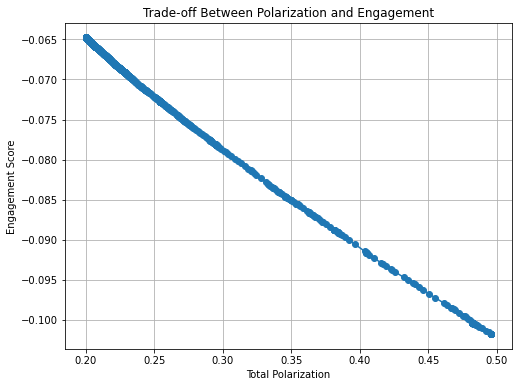

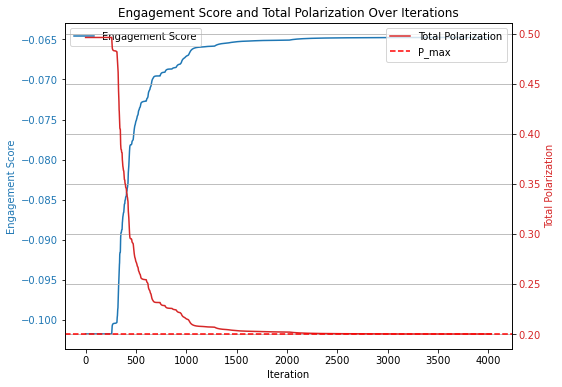

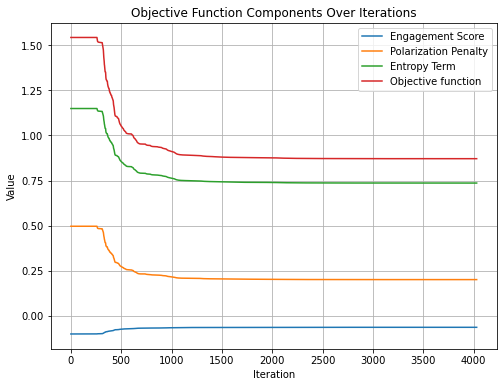

In [6]:

# a. Trade-off Between Polarization and Engagement
plt.figure(figsize=(8, 6))
plt.plot(polarization_history, engagement_history, marker='o')
plt.xlabel('Total Polarization')
plt.ylabel('Engagement Score')
plt.title('Trade-off Between Polarization and Engagement')
plt.grid(True)
plt.show()

# b. Engagement and Polarization Over Iterations
fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Engagement Score', color=color)
ax1.plot(iterations, engagement_history, color=color, label='Engagement Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Total Polarization', color=color)
ax2.plot(iterations, polarization_history, color=color, label='Total Polarization')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=0.2, color='red', linestyle='--', label='P_max')
ax2.legend(loc='upper right')

plt.title('Engagement Score and Total Polarization Over Iterations')
plt.grid(True)
plt.show()

# c. Objective Function Components Over Iterations
plt.figure(figsize=(8, 6))
plt.plot(iterations, engagement_history, label='Engagement Score')
plt.plot(iterations, [lambda_p * p for p in polarization_history], label='Polarization Penalty')
plt.plot(iterations, [o - e - lambda_p * p for e, p, o in zip(engagement_history, polarization_history, objective_history)], label='Entropy Term')
plt.plot(iterations, objective_history, label='Objective function')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Objective Function Components Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Set global figure parameters
mpl.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
    'figure.dpi': 300
})

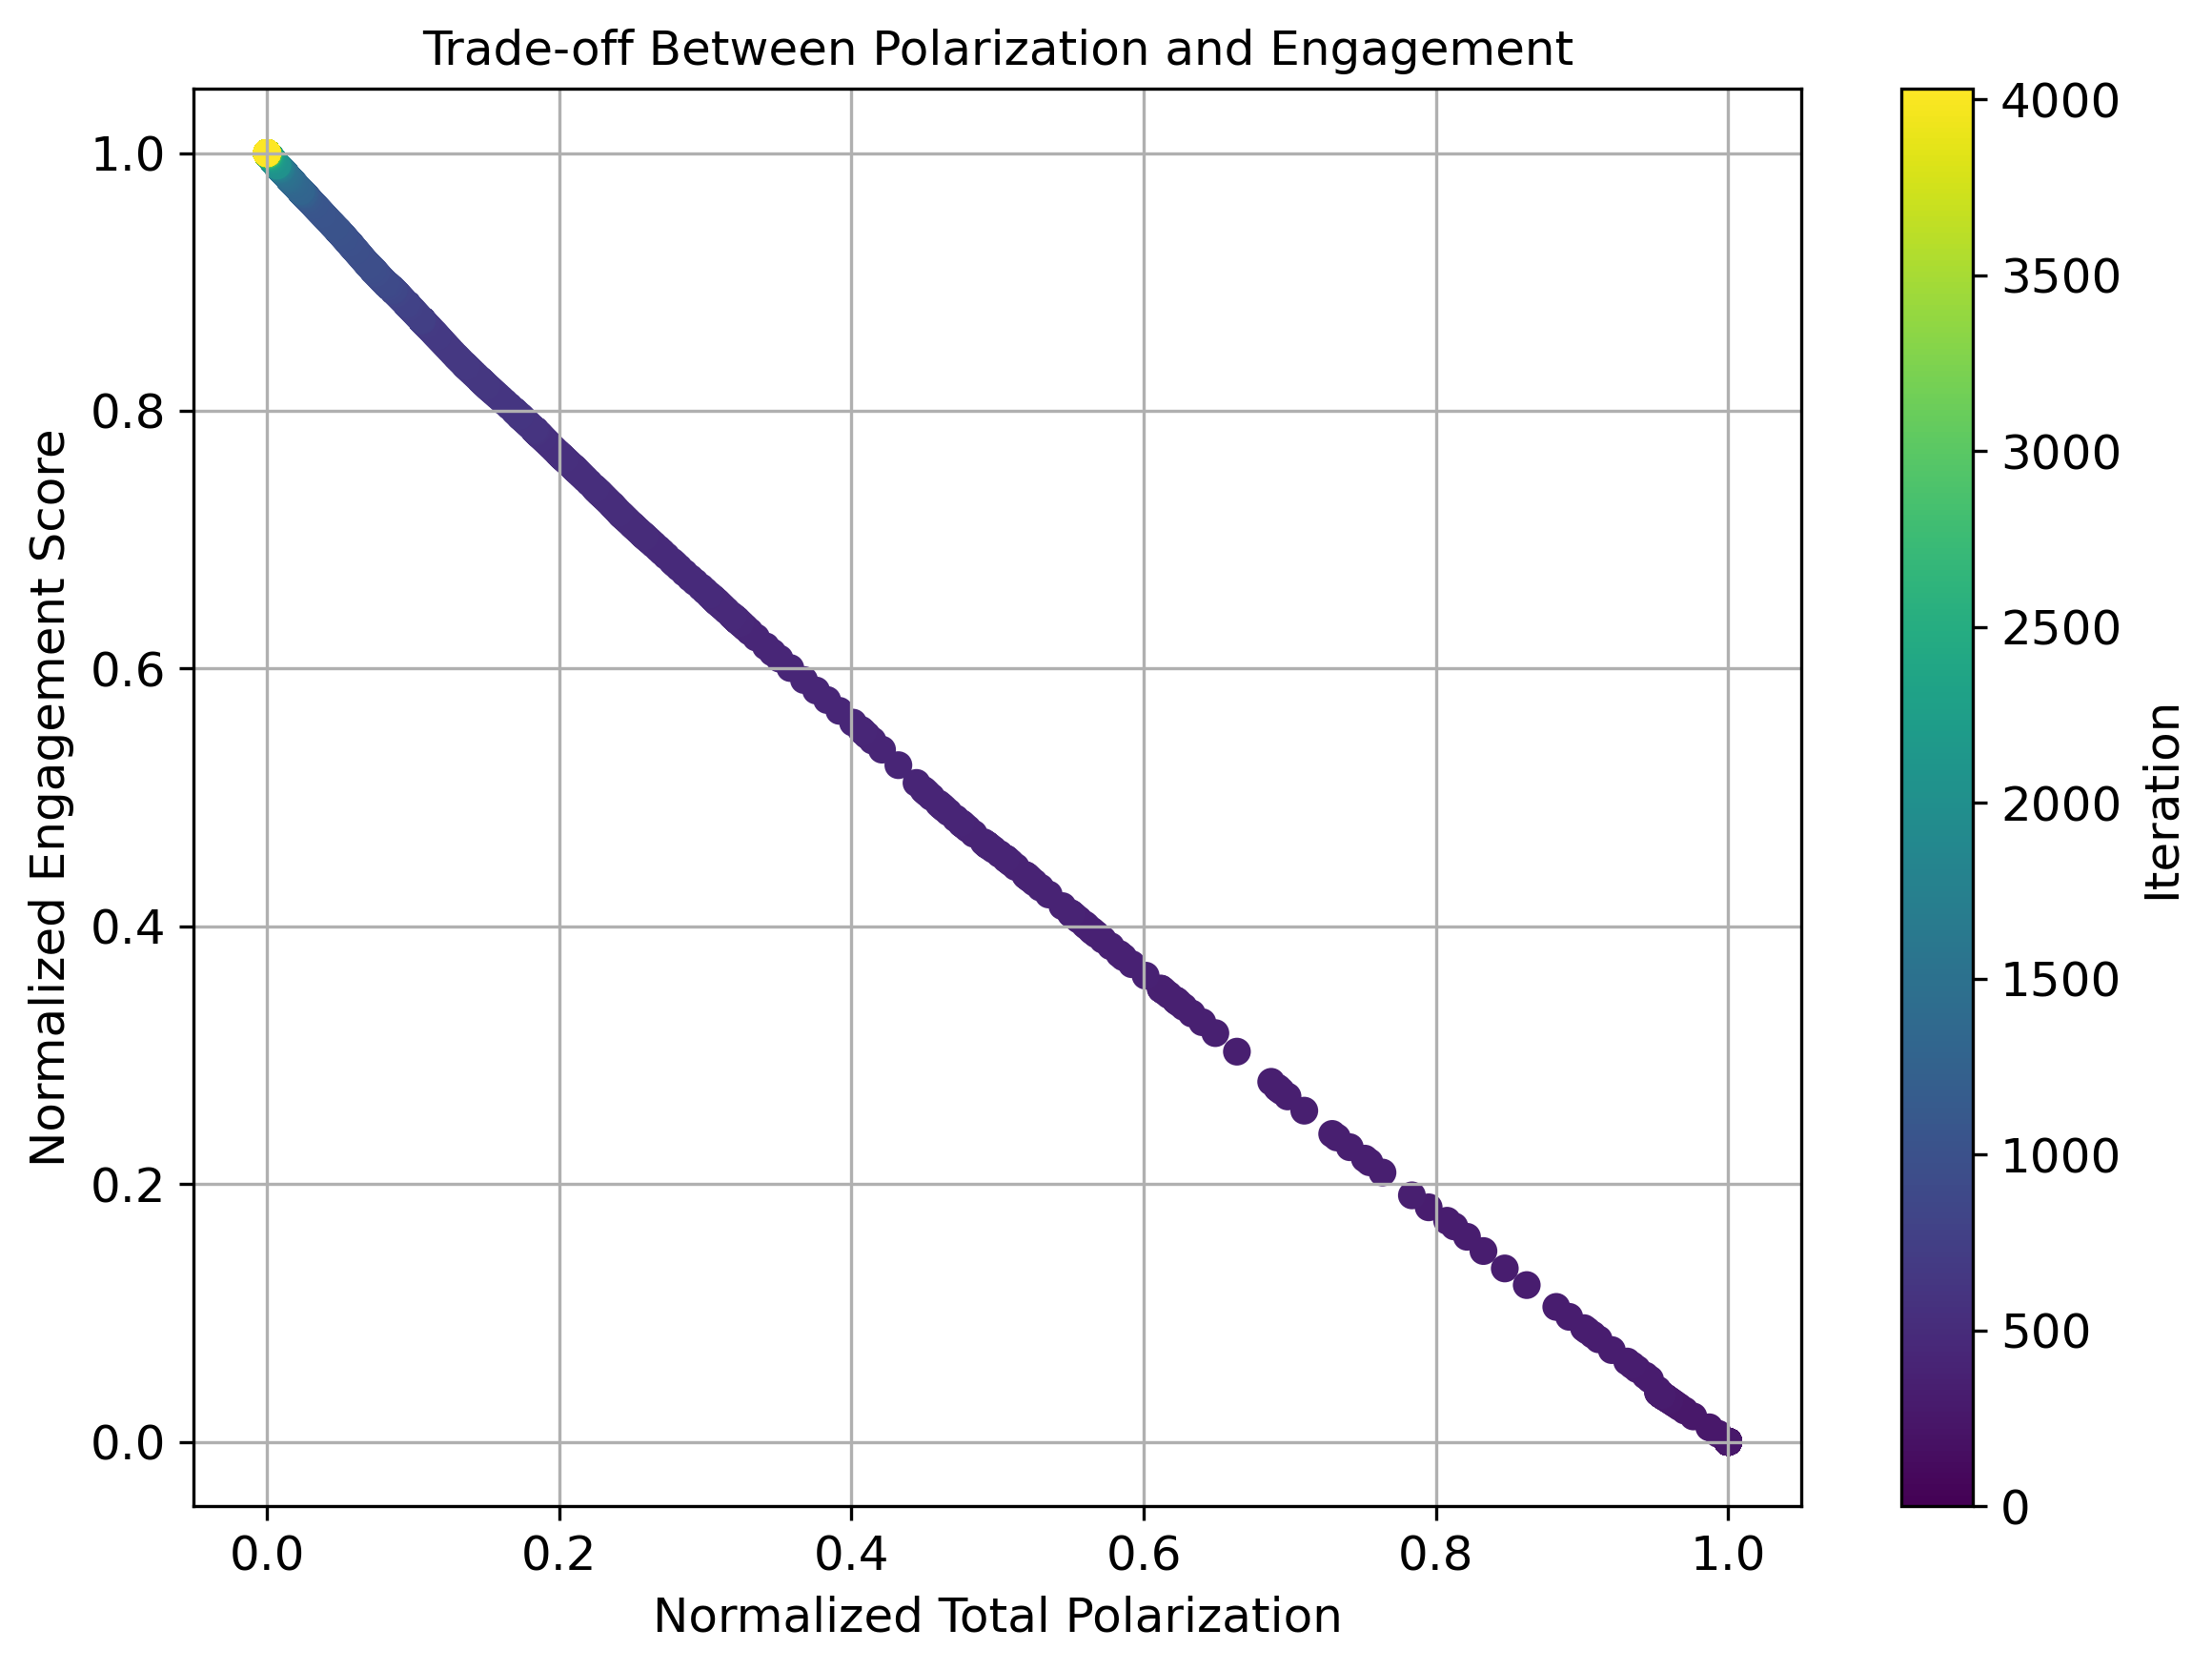

In [37]:
# Normalize engagement and polarization for better scaling
engagement_normalized = (np.array(engagement_history) - min(engagement_history)) / (max(engagement_history) - min(engagement_history))
polarization_normalized = (np.array(polarization_history) - min(polarization_history)) / (max(polarization_history) - min(polarization_history))

# Plot Trade-off Between Polarization and Engagement
plt.figure(figsize=(8, 6))
plt.scatter(polarization_normalized, engagement_normalized, c=iterations, cmap='viridis', marker='o')
plt.xlabel('Normalized Total Polarization')
plt.ylabel('Normalized Engagement Score')
plt.title('Trade-off Between Polarization and Engagement')
cbar = plt.colorbar()
cbar.set_label('Iteration')
plt.grid(True)
plt.tight_layout()
plt.savefig('tradeoff_plot.png', dpi=300)
plt.show()


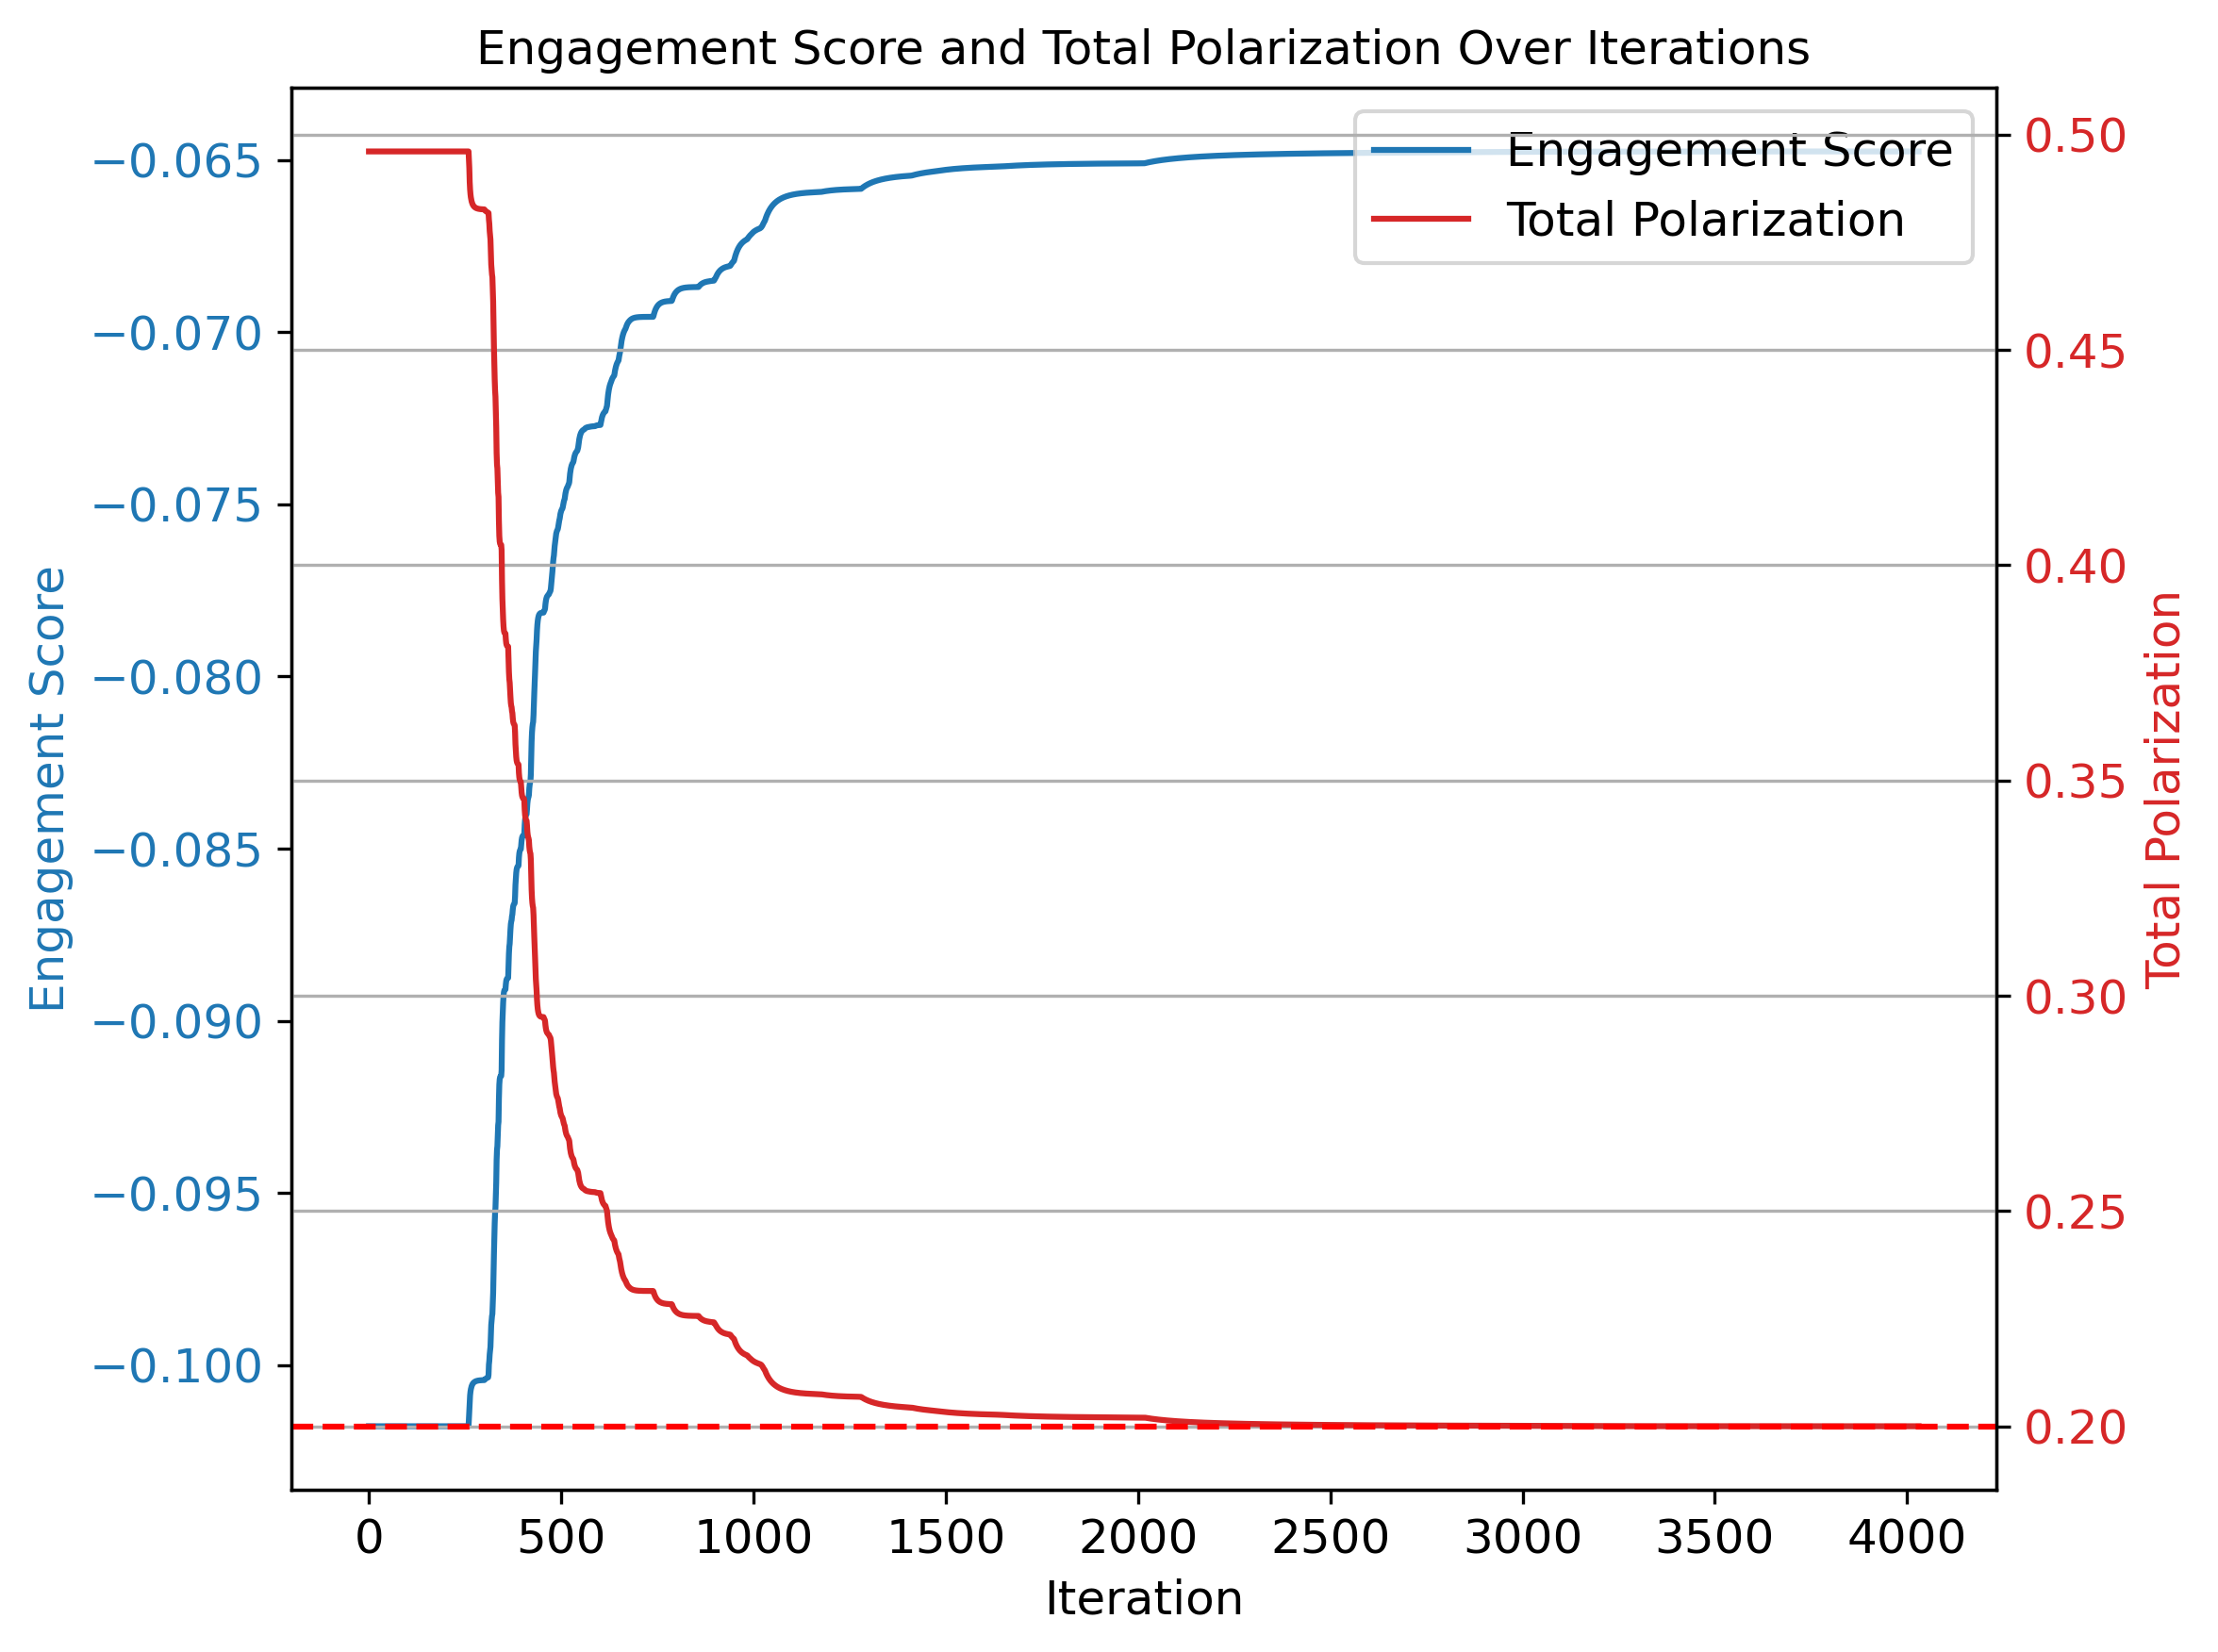

In [38]:
# Engagement and Polarization Over Iterations
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Engagement Score
color_engagement = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Engagement Score', color=color_engagement)
line1, = ax1.plot(iterations, engagement_history, color=color_engagement, label='Engagement Score')
ax1.tick_params(axis='y', labelcolor=color_engagement)

# Plot Total Polarization
ax2 = ax1.twinx()
color_polarization = 'tab:red'
ax2.set_ylabel('Total Polarization', color=color_polarization)
line2, = ax2.plot(iterations, polarization_history, color=color_polarization, label='Total Polarization')
ax2.tick_params(axis='y', labelcolor=color_polarization)
ax2.axhline(y=0.2, color='red', linestyle='--', label='P_max')

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Engagement Score and Total Polarization Over Iterations')
plt.grid(True)
plt.tight_layout()
plt.savefig('engagementVsPolarization.png', dpi=300)
plt.show()


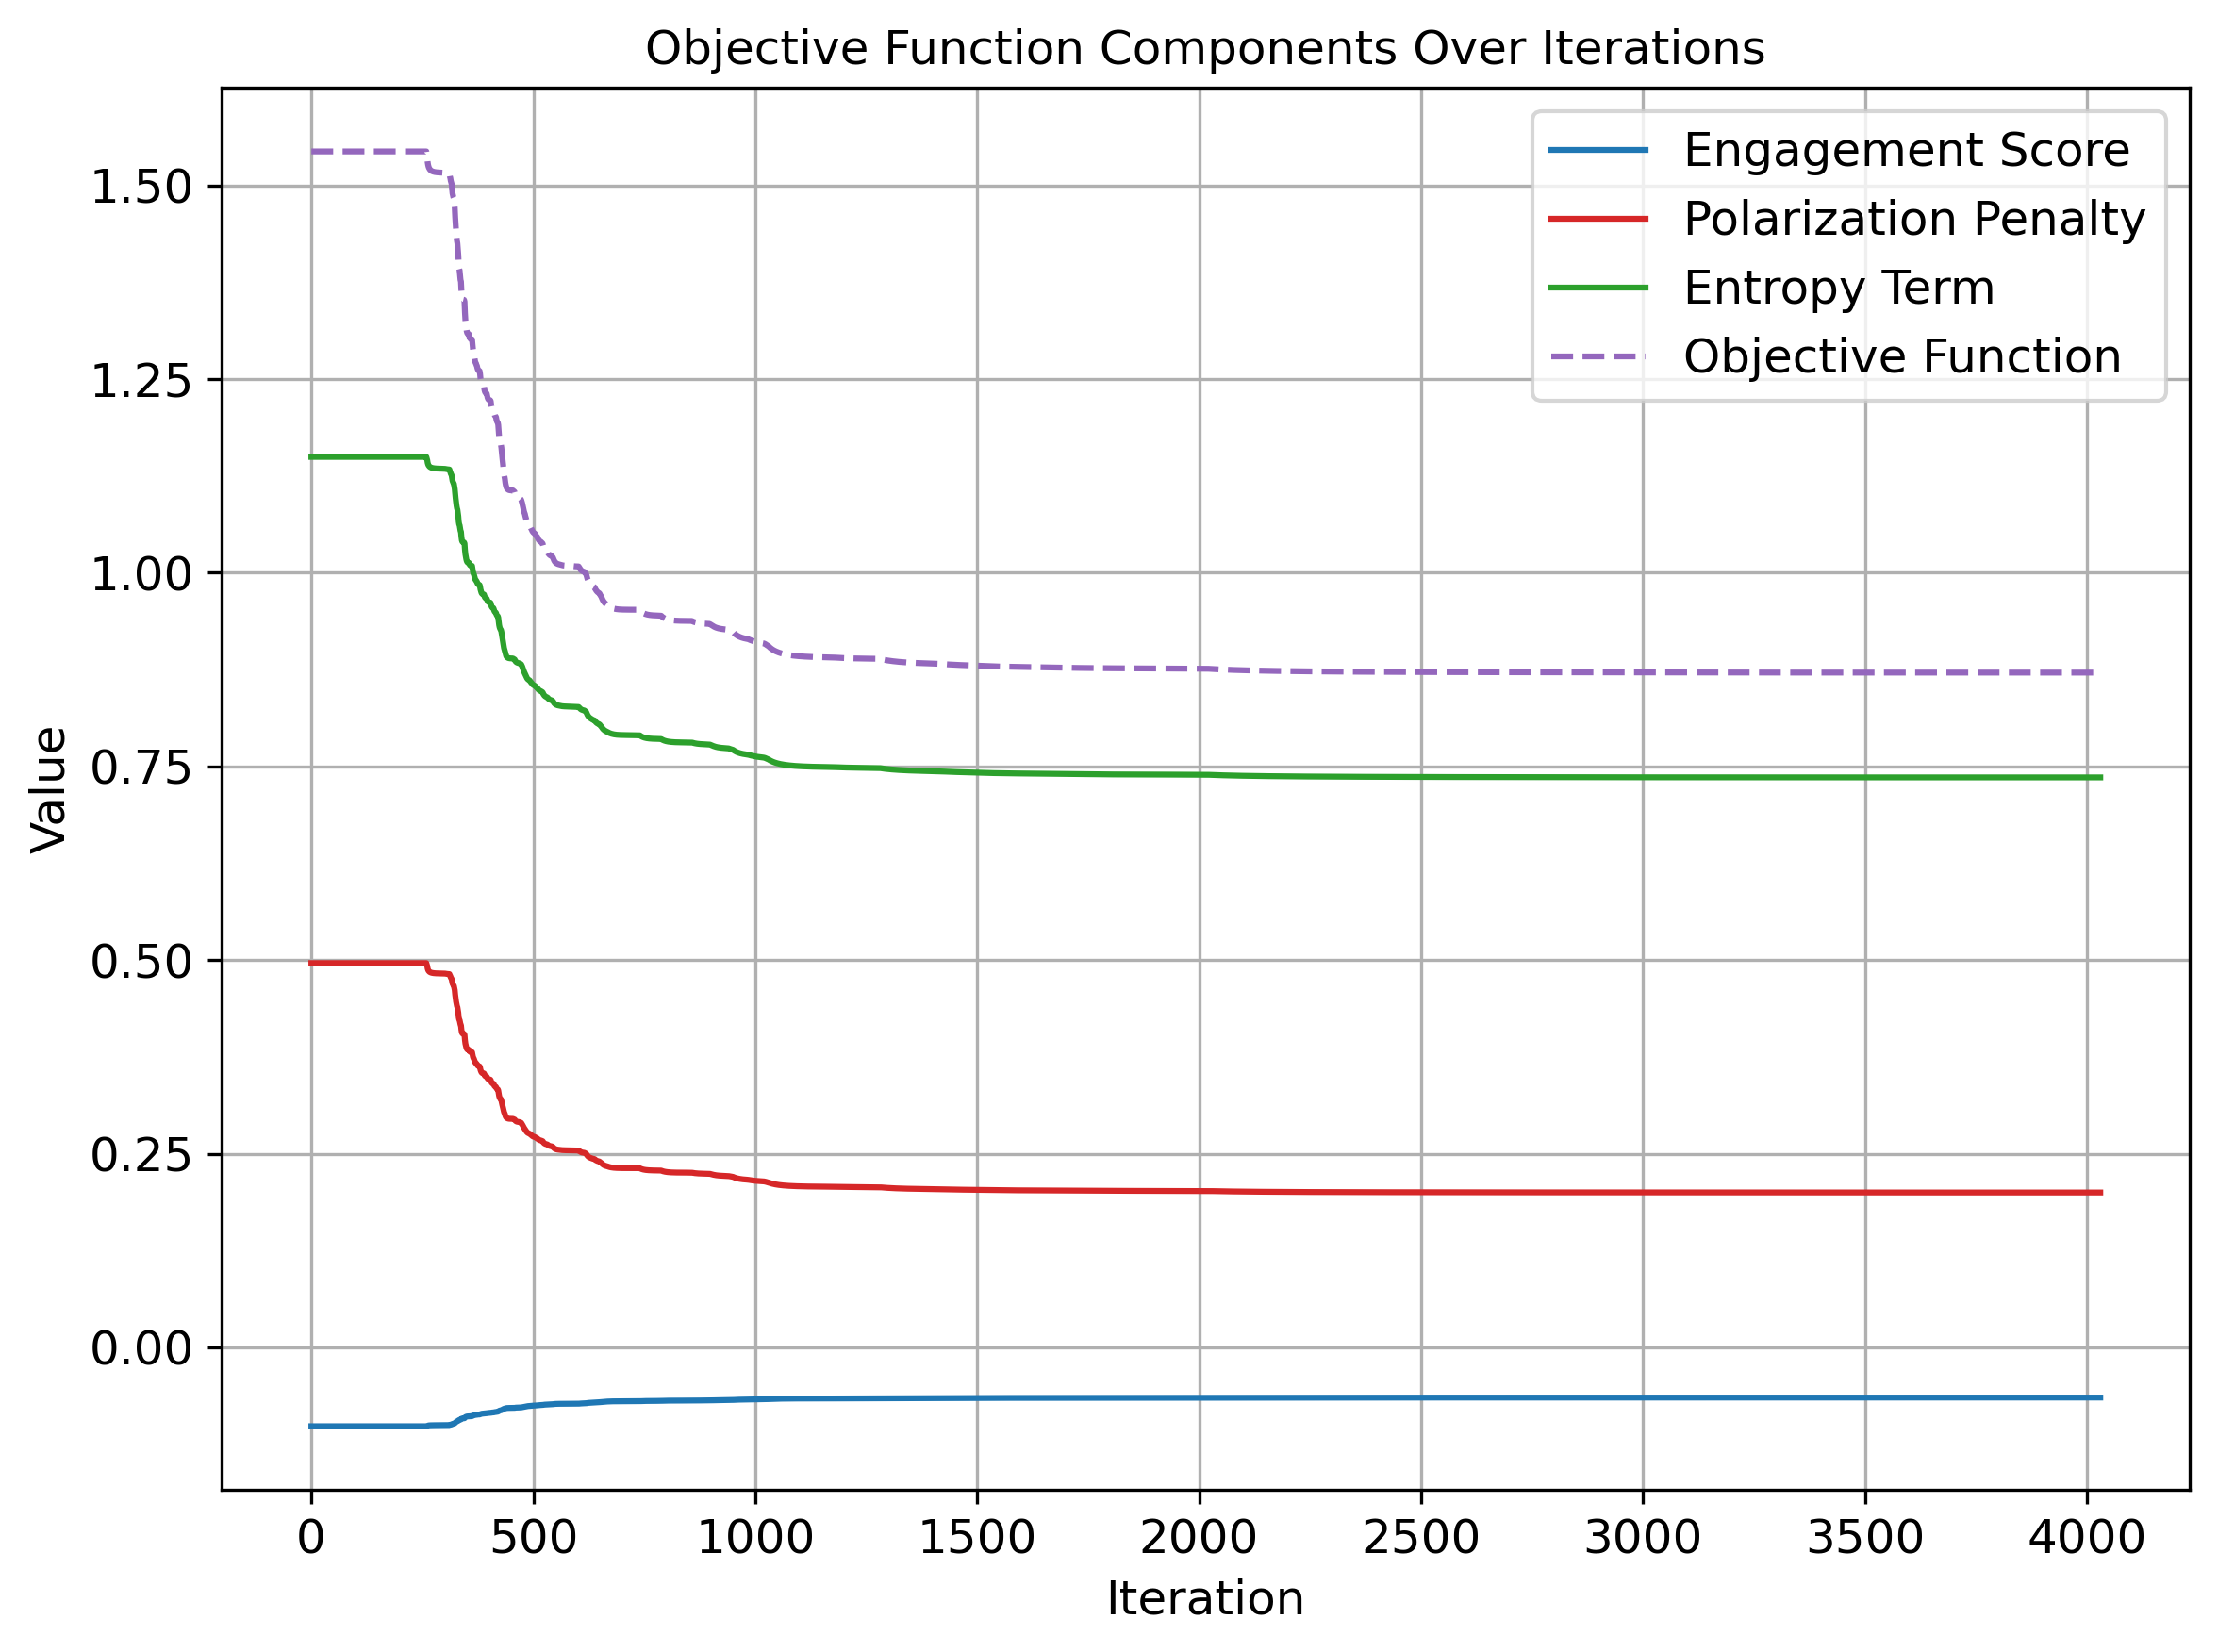

<Figure size 1800x1200 with 0 Axes>

In [ ]:
# 3. Objective Function Components Over Iterations
plt.figure(figsize=(8, 6))
plt.plot(iterations, engagement_history, label='Engagement Score', color='tab:blue')
polarization_penalty = [lambda_p * p for p in polarization_history]
plt.plot(iterations, polarization_penalty, label='Polarization Penalty', color='tab:red')
entropy_term_history = [o - e - p_penalty for e, p_penalty, o in zip(engagement_history, polarization_penalty, objective_history)]
plt.plot(iterations, entropy_term_history, label='Entropy Term', color='tab:green')
plt.plot(iterations, objective_history, label='Objective Function', color='tab:purple', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Objective Function Components Over Iterations')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig('objective_components.png', dpi=300)
plt.show()



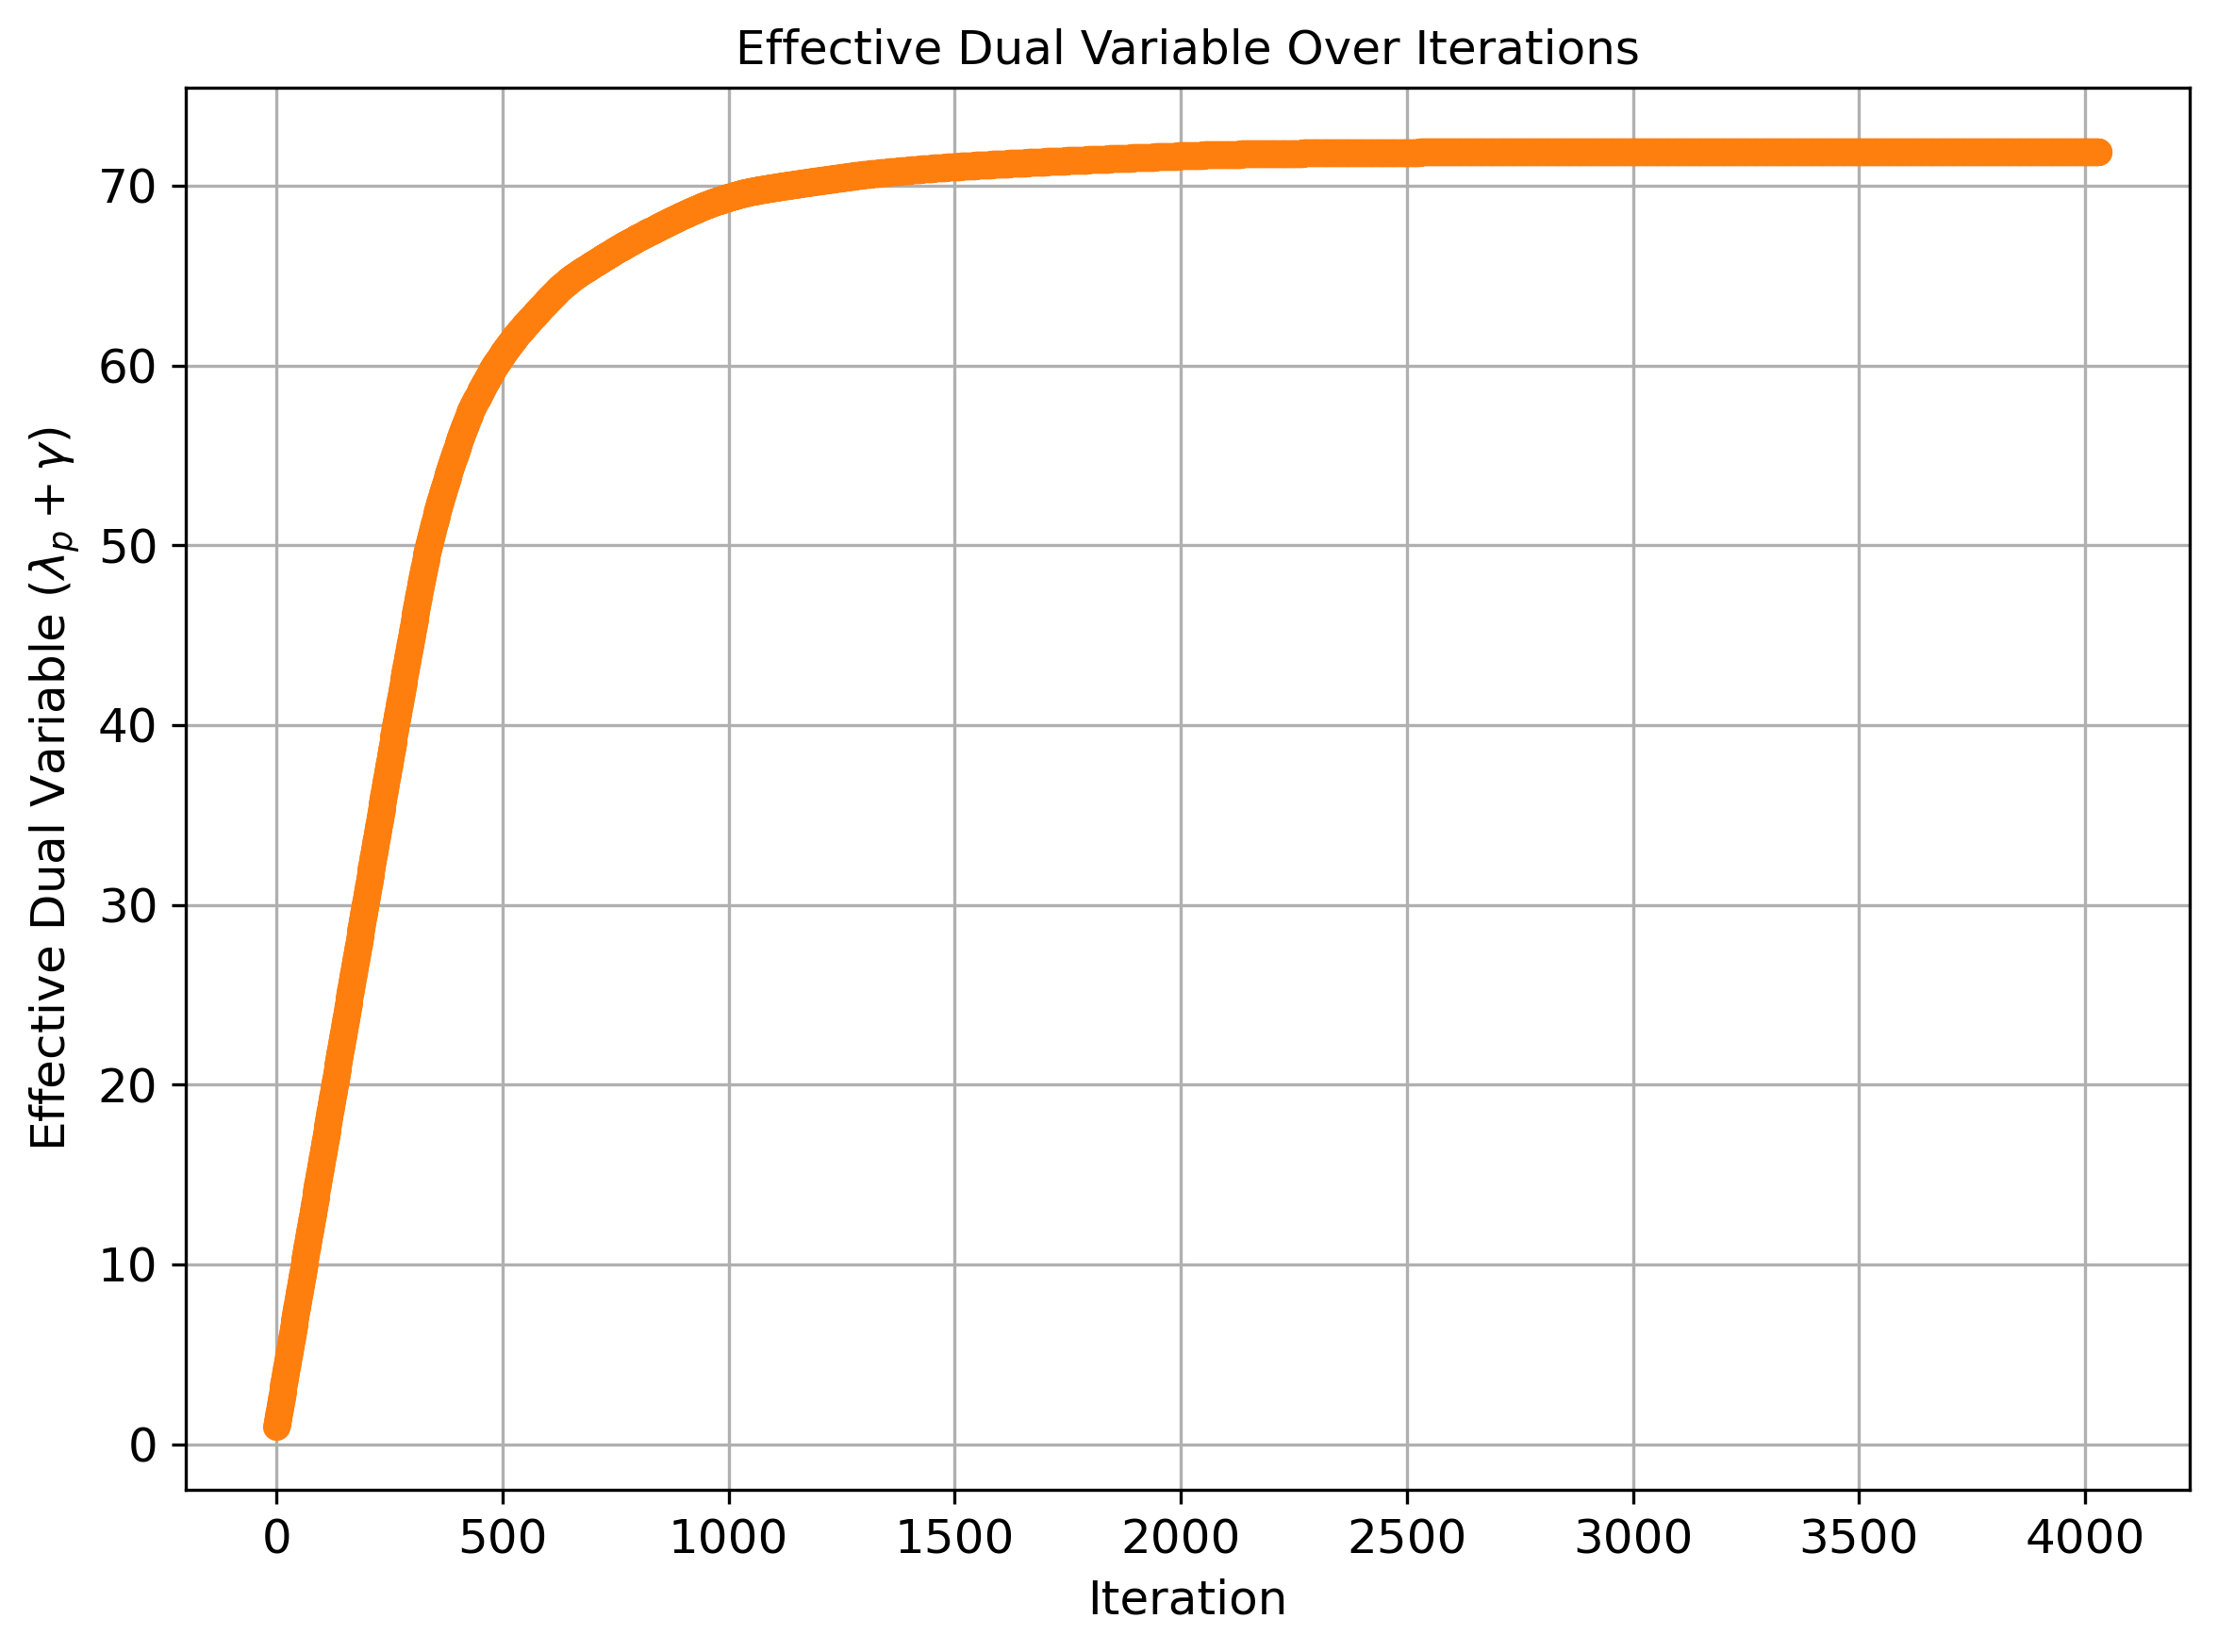

In [33]:
# 4. Effective Dual Variable Over Iterations
lambda_effective = [lambda_p + kappa for kappa in kappa_history]

plt.figure(figsize=(8, 6))
plt.plot(iterations, lambda_effective, marker='o', color='tab:orange')
plt.xlabel('Iteration')
plt.ylabel('Effective Dual Variable ($\\lambda_p + \\gamma$)')
plt.title('Effective Dual Variable Over Iterations')
plt.grid(True)
plt.tight_layout()
plt.savefig('effective_dual_variable.png', dpi=300)
plt.show()
